# Comparison of methods

In this first part, we will use the pre-computed empirical similarities between each pairwise method and compare them.

The idea is to get an understanding of how each method relates to one another using clustering techniques.

In order to re-compute the empirical similarity between each pairwise method, use the `process_mts_database.py` script (although this may not be feasible on a standard laptop).

In [3]:
import pandas
import numpy
import random

random.seed(1)

mm_adj = pandas.read_csv('data/mm_adj.csv',header=0,index_col=0)
statnames = mm_adj.columns

numpy.fill_diagonal(mm_adj.values,numpy.nan)
mm_adj

,anm,bary_dtw_max,bary_dtw_mean,bary_euclidean_max,bary_sgddtw_max,bary_sgddtw_mean,bary_softdtw_max,bary_softdtw_mean,cce_gaussian,cce_kernel_W-0.5,...,tlmi_kraskov_NN-4_DCE,wpli_multitaper_max_fs-1_fmin-0-25_fmax-0-5,wpli_multitaper_max_fs-1_fmin-0_fmax-0-25,wpli_multitaper_max_fs-1_fmin-0_fmax-0-5,wpli_multitaper_mean_fs-1_fmin-0-25_fmax-0-5,wpli_multitaper_mean_fs-1_fmin-0_fmax-0-25,wpli_multitaper_mean_fs-1_fmin-0_fmax-0-5,xcorr_max_sig-True,xcorr_mean_sig-False,xcorr_mean_sig-True
Source statistic,,,,,,,,,,,,,,,,,,,,,
anm,NaN,1.628389e-01,1.548281e-01,1.687260e-01,1.607370e-01,1.462287e-01,1.626091e-01,1.671775e-01,0.214995,0.217163,...,2.071107e-01,0.098217,0.100187,0.096365,9.111911e-02,9.192455e-02,9.626877e-02,1.988005e-01,1.838997e-01,1.795069e-01
bary_dtw_max,0.162839,NaN,2.027443e-01,6.477474e-01,6.559101e-01,1.923402e-01,7.511788e-01,2.298296e-01,0.207820,0.144580,...,2.303810e-01,0.088809,0.086540,0.092968,9.483721e-10,1.744748e-09,9.460279e-09,2.893172e-01,2.543113e-01,2.424879e-01
bary_dtw_mean,0.154828,2.027443e-01,NaN,2.161415e-01,2.092053e-01,5.457060e-01,1.926368e-01,2.678172e-01,0.169504,0.120563,...,2.302929e-01,0.087658,0.088871,0.088465,1.735360e-09,3.354771e-09,5.990267e-09,2.572616e-01,2.089434e-01,2.107027e-01
bary_euclidean_max,0.168726,6.477474e-01,2.161415e-01,NaN,8.016686e-01,2.151985e-01,5.309159e-01,2.397957e-01,0.206122,0.145503,...,2.375066e-01,0.094711,0.086462,0.094679,5.098559e-09,7.422641e-09,5.203952e-09,3.092295e-01,2.316964e-01,2.334032e-01
bary_sgddtw_max,0.160737,6.559101e-01,2.092053e-01,8.016686e-01,NaN,2.134298e-01,5.643723e-01,2.350540e-01,0.205290,0.148867,...,2.367219e-01,0.094533,0.084933,0.092692,9.302393e-09,6.924543e-09,2.028296e-08,3.091696e-01,2.450937e-01,2.430105e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wpli_multitaper_mean_fs-1_fmin-0_fmax-0-25,0.091925,1.744748e-09,3.354771e-09,7.422641e-09,6.924543e-09,2.859906e-08,3.845515e-09,6.420359e-09,0.124151,0.166450,...,3.876893e-09,0.175466,0.482224,0.331378,2.762827e-01,NaN,7.212857e-01,1.528278e-08,3.905387e-08,1.510396e-08
wpli_multitaper_mean_fs-1_fmin-0_fmax-0-5,0.096269,9.460279e-09,5.990267e-09,5.203952e-09,2.028296e-08,3.233039e-08,3.005142e-09,2.789995e-09,0.127715,0.155272,...,1.176972e-08,0.372940,0.380380,0.409245,7.014512e-01,7.212857e-01,NaN,3.993953e-08,2.558771e-08,2.946789e-08
xcorr_max_sig-True,0.198801,2.893172e-01,2.572616e-01,3.092295e-01,3.091696e-01,2.521785e-01,2.608345e-01,3.027015e-01,0.311062,0.180657,...,3.941087e-01,0.105165,0.103215,0.107940,8.972725e-09,1.528278e-08,3.993953e-08,NaN,2.891007e-01,3.439773e-01


In [4]:
import matplotlib.pyplot as plt
import matplotlib
from scipy.cluster import hierarchy

method = 'weighted'

y = 1 - mm_adj.fillna(0).values[numpy.triu_indices(mm_adj.shape[0], 1)]
Z = hierarchy.linkage(y, metric='euclidean', method=method, optimal_ordering=True)

threshold = 0.76
clusters = hierarchy.fcluster(Z, threshold, criterion='distance')
nclusters = numpy.unique(clusters).size

cm = numpy.genfromtxt('data/cmap.csv', delimiter=',')
cmap = [matplotlib.colors.rgb2hex(c / 255 + (0,)) for c in cm]

hierarchy.set_link_color_palette(cmap)

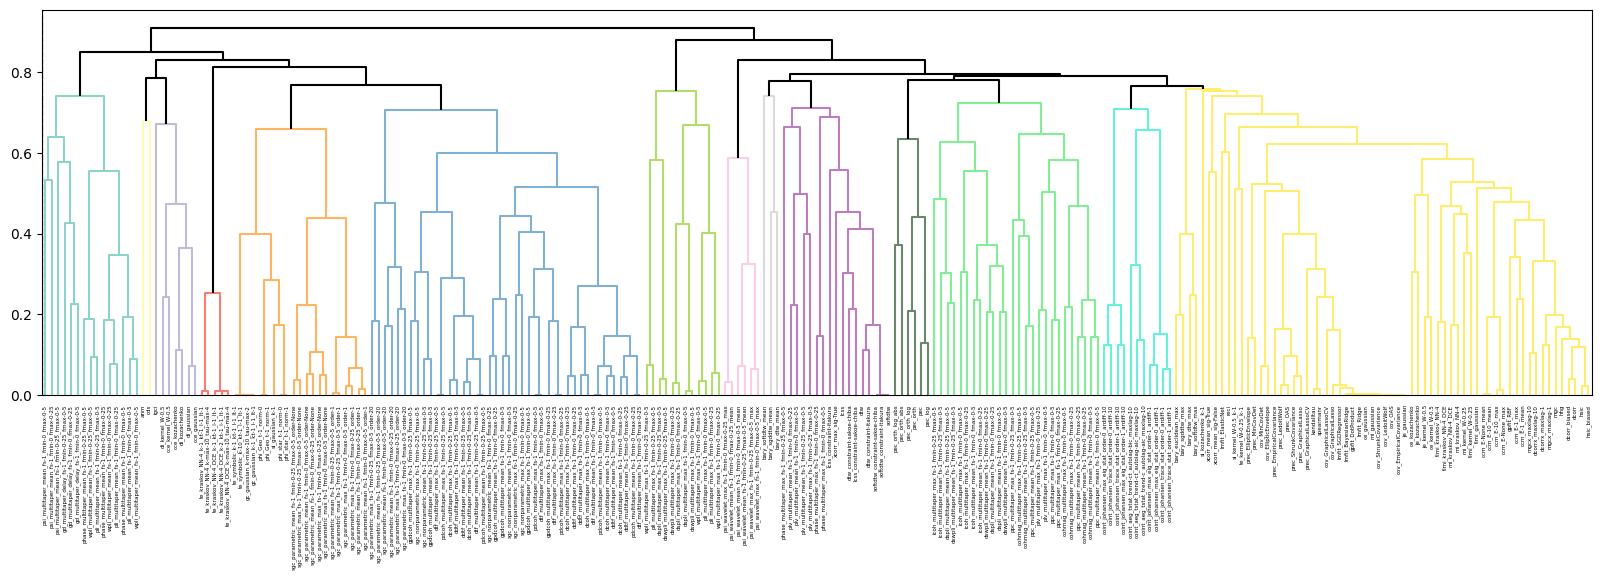

In [5]:
fig, ax = plt.subplots(figsize=(20, 5))
dn = hierarchy.dendrogram(Z, labels=statnames, orientation='top',
                            color_threshold=threshold, leaf_font_size=4,
                            count_sort='ascending', above_threshold_color='k')
plt.axvline(x=threshold, c='grey', lw=1, linestyle='dashed')

In [6]:
# Wrapper functions for network generation using networkx
import networkx

def _reweight(x, thresholds=(0.75,0.5,0.25), weights=(2,0.75,0.1)):
    for t, w in zip(thresholds, weights):
        if x >= t:
            return w
    return 0

def _nudge(pos, x_shift, y_shift):
    return {n: (x + x_shift, y + y_shift) for n, (x,y) in pos.items()}

def draw_network(adj, spi=None, squared=False, node_color=None, \
                 color_labels=None, labels_on=False, pos=None, \
                 layout='spring', seed=1, use_kk=True, savedir=None, \
                 thresholds=None, weights=None, alpha=None, figsize=(12,10)):

    adj = adj.copy(deep=True).fillna(0)

    if thresholds is None:
        if adj.shape[0] < 50:
            thresholds = (0.9,0.7,0.5)
        else:
            vec = adj.values[numpy.triu_indices(adj.shape[0],1)]
            thresholds = numpy.percentile(vec[~numpy.isnan(vec)], [99, 95, 90])

    if weights is None:
        weights = (2,0.75,0.1)

    if squared:
        adj = adj**2
        thresholds = [t**2 for t in thresholds]

    if alpha is None:
        alpha = 1

    if node_color is None:
        node_color = {s: (0., 0., 0.) for s in adj}
    else:
        # If any nodes aren't in the map, set them to black
        for spi in adj:
            node_color.setdefault(spi, (0., 0., 0.))

    G = networkx.from_pandas_adjacency(adj)

    if spi is not None:
        fig, ax = plt.subplots(1, figsize=figsize)

        if layout == 'spring':
            if pos is None:
                if use_kk:
                    pos = networkx.kamada_kawai_layout(G)
                else:
                    pos = None
            pos = networkx.spring_layout(G,pos=pos,seed=seed,iterations=1000)
        elif pos is None:
            raise ValueError('pos must be included if layout is not spring.')

        weights = [_reweight(G[u][v]['weight'], thresholds, weights) for u, v in G.edges()]

        networkx.draw(G, pos=pos, ax=ax, with_labels=False, node_size=250,
                        edgecolors='k', edge_color=None, width=weights,
                        node_color=[node_color[f] for f in pos], alpha=alpha)

        pos_labels = _nudge(pos, 0,0.02)
        if labels_on:
            networkx.draw_networkx_labels(G, pos=pos_labels, ax=ax, font_size=6)
            plt.margins(x=0.4)
    else:
        fig, ax = plt.subplots(1, figsize=figsize)
        weights = [_reweight(G[u][v]['weight'], thresholds, weights) for u, v in G.edges()]

        if layout == 'spring':
            if use_kk:
                pos = networkx.kamada_kawai_layout(G)
            else:
                pos = None
            pos = networkx.spring_layout(G, seed=seed, pos=pos, iterations=1000)
        elif pos is None:
            raise ValueError('pos must be included if layout is not spring.')

        networkx.draw_networkx_nodes(G, pos=pos, ax=ax, node_size=150,
                                            edgecolors=[[0.8*c for c in node_color[f]] for f in pos],
                                            node_color=[node_color[f] for f in pos],
                                            linewidths=1, alpha=alpha)
        networkx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color=None, width=weights, alpha=alpha)

        if labels_on:
            networkx.draw_networkx_labels(G, pos=pos, ax=ax, font_size=1)
            plt.margins(x=0.4)
        
    ax = plt.gca()
    if color_labels is not None:
        ns = []
        for l in color_labels:
            ns.append(ax.scatter([], [], color=color_labels[l], label=l))

        lines = []
        for t, w in zip(thresholds, weights):
            if squared:
                l, = ax.plot([],[], color='k', linewidth=w, label=f'|r| > {numpy.sqrt(t):.2f}')
            else:
                l, = ax.plot([],[], color='k', linewidth=w, label=f'|r| > {t:.2f}')
            lines.append(l)
        legend1 = plt.legend(lines,[l.get_label() for l in lines],loc=3)
        ax.legend(ns,[n.get_label() for n in ns], loc=1)
        ax.add_artist(legend1)

    plt.tight_layout()
    plt.axis('off')

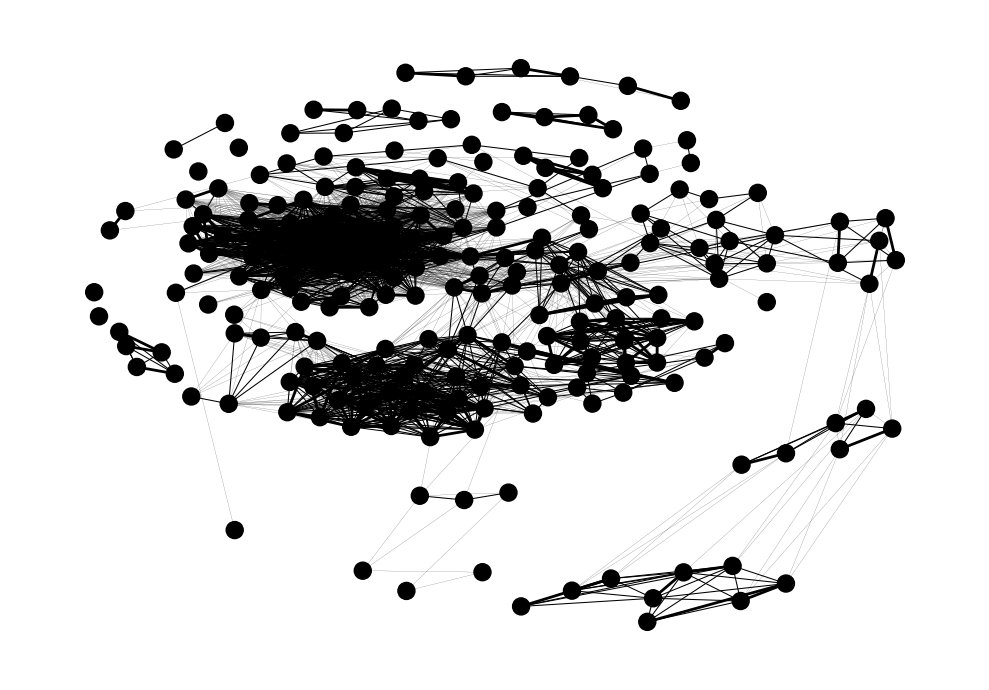

In [7]:
# Network without module colours can be difficult to interpret..
draw_network(mm_adj, squared=True, figsize=(10, 7))

In [9]:
# ...so let's get the colours of each node and cluster for re-plotting
try:
    colour_list = dn["leaves_color_list"]
except KeyError:
    # The legacy versions of scipy don't have the leaves_color_list output
    def _get_leaves_color_list(R):
        leaves_color_list = [None] * len(R['leaves'])
        for link_x, link_y, link_color in zip(R['icoord'],
                                            R['dcoord'],
                                            R['color_list']):
            for (xi, yi) in zip(link_x, link_y):
                if yi == 0.0:  # if yi is 0.0, the point is a leaf
                    # xi of leaves are      5, 15, 25, 35, ... (see `iv_ticks`)
                    # index of leaves are   0,  1,  2,  3, ... as below
                    leaf_index = (int(xi) - 5) // 10
                    # each leaf has a same color of its link.
                    leaves_color_list[leaf_index] = link_color
        return leaves_color_list

    dn['leaves_color_list'] = _get_leaves_color_list(dn)
    colour_list = dn['leaves_color_list']

# Assign node colours
node_colours = {s : matplotlib.colors.hex2color(c) for s, c in zip(dn["ivl"], dn["leaves_color_list"])}

In [10]:
_, uidx = numpy.unique(colour_list, return_index=True)
unique_modules = numpy.array(colour_list)[numpy.sort(uidx)]

# Assign module colours
module_colours = {f'M{i+1:02d}' : matplotlib.colors.hex2color(c) for i, c in enumerate(unique_modules)}

module_colours['Singleton'] = (0,0,0)
del module_colours[[k for k, v in zip(module_colours.keys(), module_colours.values()) if v == (0,0,0)][0]]


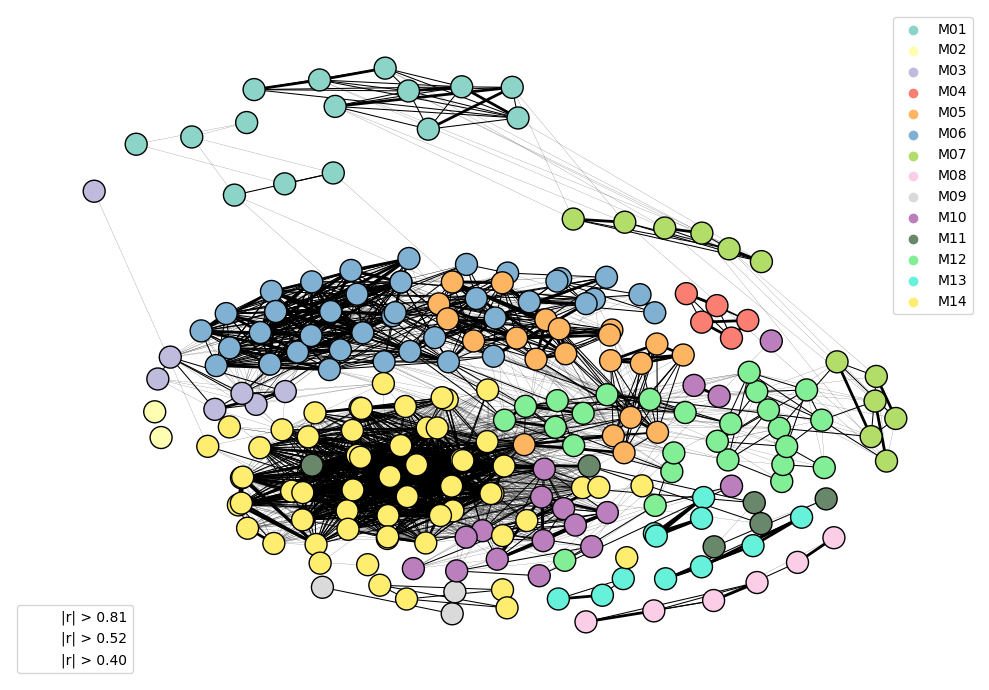

In [11]:
# Now we can re-draw network with the module colours
draw_network(mm_adj, node_color=node_colours, color_labels=module_colours, figsize=(10, 7))

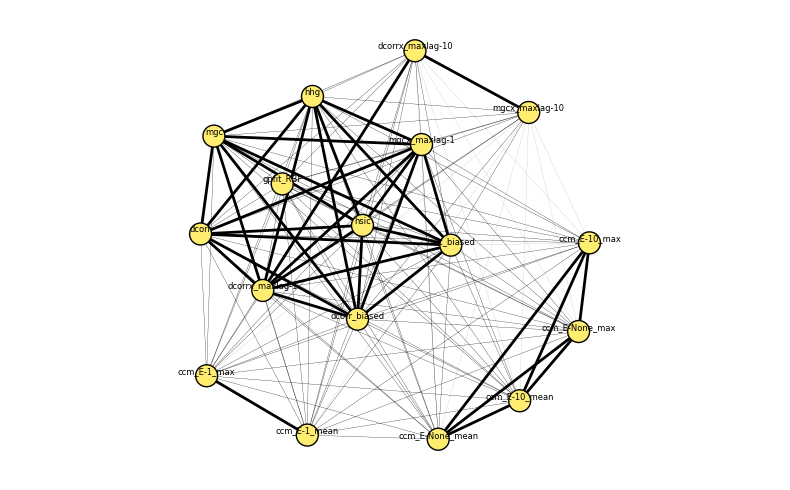

In [12]:

# Let's zoom in to the distance correlation SPI and the other SPIs in that cluster
spi = 'dcorr' # distance correlation
cutoff = 0.5

def get_stat_cluster(spi, cutoff):
    modules = hierarchy.fcluster(Z, cutoff, criterion='distance')
    spi_mod = modules[numpy.where(statnames == spi)[0]]
    return statnames[modules == spi_mod]

stat_in_cluster = get_stat_cluster(spi, cutoff)

statadj = mm_adj.loc[stat_in_cluster, stat_in_cluster]

thresholds = (0.75,0.5,0.25)
weights = (2,0.2,0.05)

draw_network(statadj, spi=spi, squared=True,
                node_color=node_colours, seed=1, pos=None, labels_on=True,
                thresholds=thresholds, weights=weights, figsize=(8, 5))

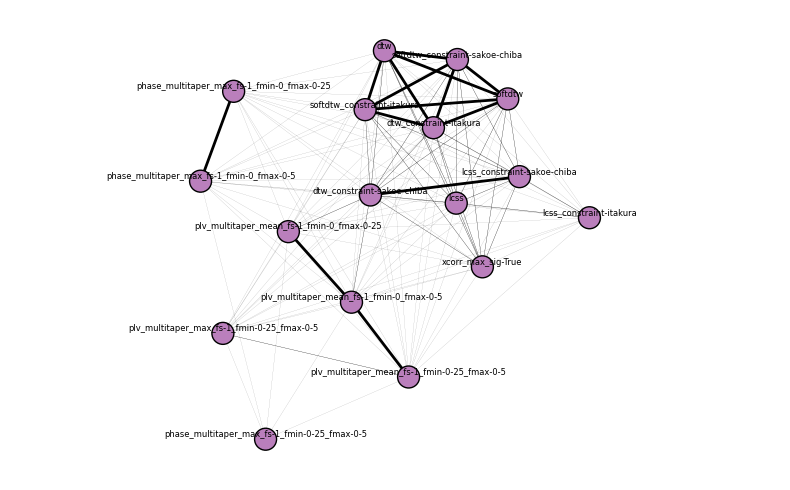

In [13]:
stat = 'lcss' # longest common subsequence
cutoff = 0.75

stat_in_cluster = get_stat_cluster(stat, cutoff)

statadj = mm_adj.loc[stat_in_cluster, stat_in_cluster]

draw_network(statadj, spi=spi, squared=True,
                node_color=node_colours, seed=1, pos=None, labels_on=True,
                thresholds=thresholds, weights=weights, figsize=(8, 5))

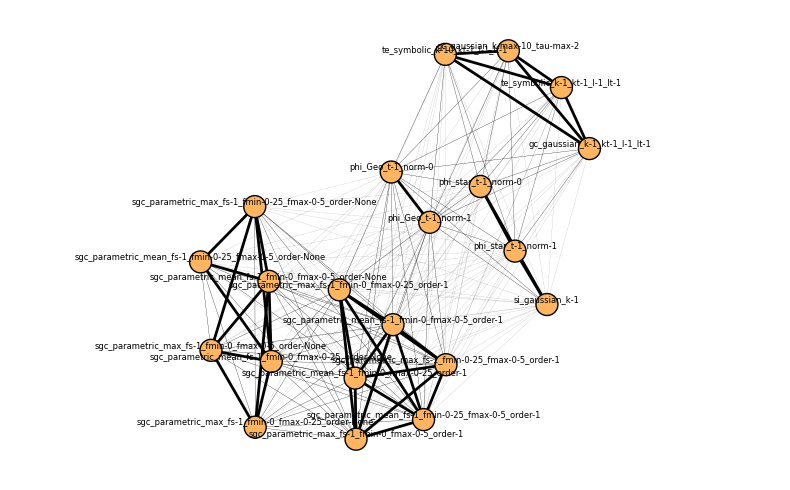

In [14]:
# Granger causality with a history length of 10 and a time delay of 2
stat = 'gc_gaussian_k-max-10_tau-max-2'
cutoff = 0.7

stat_in_cluster = get_stat_cluster(stat, cutoff)

statadj = mm_adj.loc[stat_in_cluster, stat_in_cluster]

draw_network(statadj, spi=spi, squared=True,
                node_color=node_colours, seed=1, pos=None, labels_on=True,
                thresholds=thresholds, weights=weights, figsize=(8, 5))